In [7]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import os

# Function to load data safely
def load_data(path):
    if not os.path.exists(path):
        print(f"Warning: {path} not found.")
        return None
    
    data = loadmat(path)
    # Logic to find the correct variable in the .mat file
    for k, v in data.items():
        if k.startswith('__'): continue
        if isinstance(v, np.ndarray):
            # 3D is the data cube, 2D is the ground truth map
            if v.ndim == 3 or v.ndim == 2:
                return v.astype(float)
    return None

# Function to normalize data to 0-1 range
def normalize(img):
    min_val = np.min(img)
    max_val = np.max(img)
    if max_val == min_val:
        return img
    return (img - min_val) / (max_val - min_val)

print("Setup complete. Functions defined.")

Setup complete. Functions defined.


In [8]:
def log_transform(img):
    # Formula: s = c * log(1 + r)
    normalized = normalize(img)
    # c is implied by the final normalization
    result = np.log(1 + normalized)
    return normalize(result)

def gamma_correction(img, gamma=0.5):
    # Formula: s = c * r^gamma
    normalized = normalize(img)
    result = np.power(normalized, gamma)
    return result

def contrast_stretching(img):
    # Linear stretch between 2nd and 98th percentiles
    flat = img.flatten()
    flat_sorted = np.sort(flat)
    n = len(flat_sorted)
    
    low_idx = int(0.02 * n)
    high_idx = int(0.98 * n)
    
    low_val = flat_sorted[low_idx]
    high_val = flat_sorted[high_idx]
    
    # (pixel - min) / (max - min)
    result = (img - low_val) / (high_val - low_val)
    result = np.clip(result, 0, 1)
    return result

def histogram_equalization(img):
    normalized = normalize(img)
    # Convert to integer 0-255 for histogram binning
    img_int = (normalized * 255).astype(int)
    
    # 1. Histogram
    hist = np.zeros(256)
    for val in img_int.flatten():
        hist[val] += 1
    
    # 2. Cumulative Distribution Function (CDF)
    cdf = np.zeros(256)
    cdf[0] = hist[0]
    for i in range(1, 256):
        cdf[i] = cdf[i-1] + hist[i]
    
    # 3. Normalize CDF
    cdf = cdf / cdf[-1]
    
    # 4. Map back
    result = np.zeros_like(img)
    rows, cols = img.shape
    for i in range(rows):
        for j in range(cols):
            result[i, j] = cdf[img_int[i, j]]
            
    return result

print("Intensity algorithms defined.")

Intensity algorithms defined.


In [9]:
def convolve2d(img, kernel):
    h, w = img.shape
    kh, kw = kernel.shape
    pad_h = kh // 2
    pad_w = kw // 2
    
    # Pad with edge values to prevent dark borders
    padded = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode='edge')
    result = np.zeros_like(img)
    
    # Manual convolution loops (From Scratch)
    for i in range(h):
        for j in range(w):
            patch = padded[i:i+kh, j:j+kw]
            result[i, j] = np.sum(patch * kernel)
            
    return result

def mean_filter(img, size=3):
    kernel = np.ones((size, size)) / (size * size)
    return convolve2d(img, kernel)

def gradient_filter(img):
    # Sobel Operators
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]], dtype=float)
    
    sobel_y = np.array([[-1, -2, -1],
                        [0,  0,  0],
                        [1,  2,  1]], dtype=float)
    
    gx = convolve2d(img, sobel_x)
    gy = convolve2d(img, sobel_y)
    
    magnitude = np.sqrt(gx**2 + gy**2)
    return normalize(magnitude)

print("Spatial filters defined.")

Spatial filters defined.


Corrected Data Shape: (145, 145, 200)


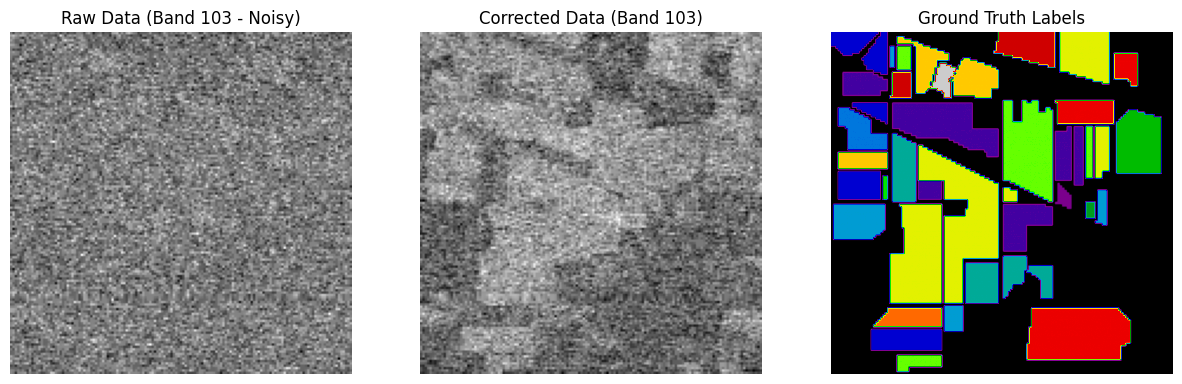

In [10]:
# Load all 3 datasets
cube_corr = load_data('Indian_pines_corrected.mat')
cube_raw = load_data('Indian_pines.mat')
gt_map = load_data('Indian_pines_gt.mat')

if cube_corr is None:
    print("Error: Indian_pines_corrected.mat is missing!")
else:
    print(f"Corrected Data Shape: {cube_corr.shape}")
    # Prepare the main image for processing (Average of all bands)
    band = np.mean(cube_corr, axis=2)
    band = normalize(band)

    # Visualization: Comparison
    plt.figure(figsize=(15, 5))
    
    # 1. Noisy Raw Band
    if cube_raw is not None:
        plt.subplot(1, 3, 1)
        plt.imshow(normalize(cube_raw[:, :, 103]), cmap='gray') # Band 103 is usually noisy
        plt.title('Raw Data (Band 103 - Noisy)')
        plt.axis('off')

    # 2. Clean Corrected Band
    plt.subplot(1, 3, 2)
    plt.imshow(normalize(cube_corr[:, :, 103]), cmap='gray')
    plt.title('Corrected Data (Band 103)')
    plt.axis('off')
    
    # 3. Ground Truth
    if gt_map is not None:
        plt.subplot(1, 3, 3)
        plt.imshow(gt_map, cmap='nipy_spectral')
        plt.title('Ground Truth Labels')
        plt.axis('off')

    plt.show()

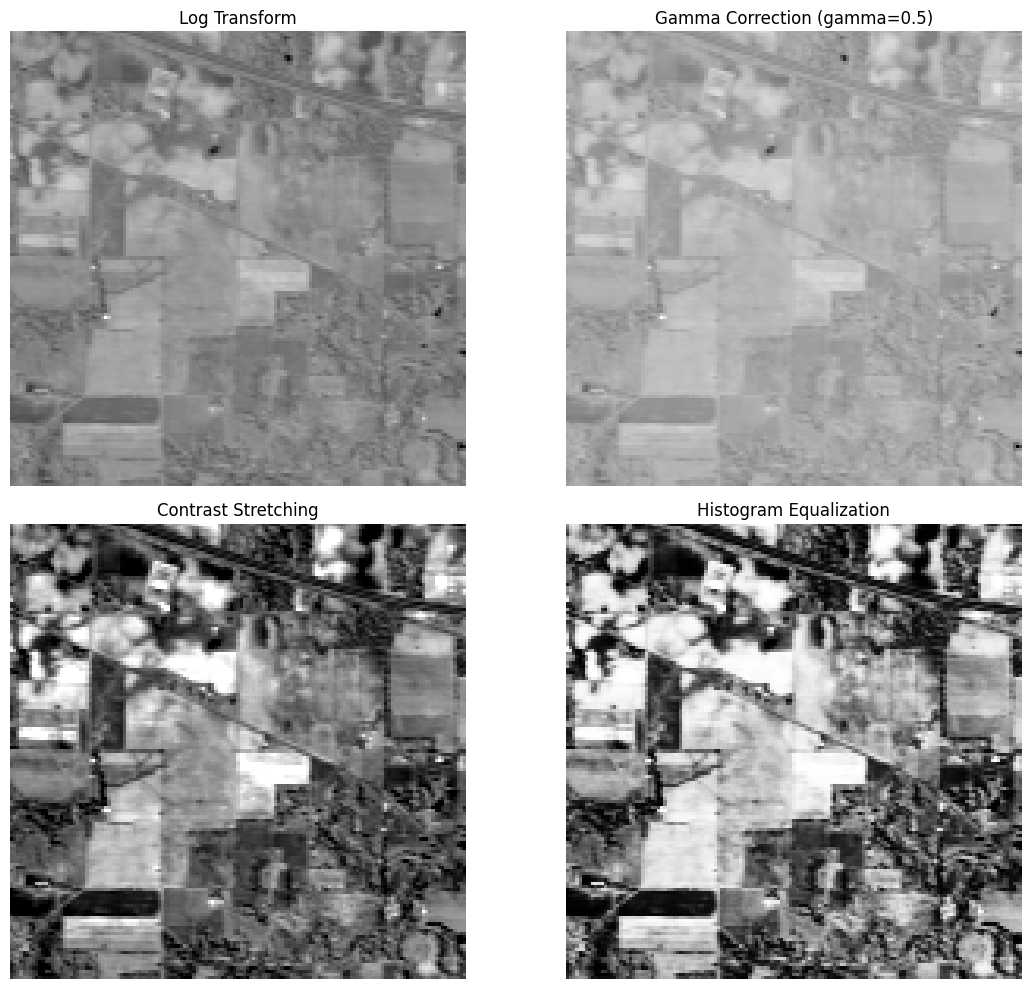

In [11]:
# Create output directory if it doesn't exist
os.makedirs('outputs', exist_ok=True)

# 1. Log Transform
log_res = log_transform(band)
# 2. Gamma Correction (Brightening)
gamma_res = gamma_correction(band, gamma=0.5)
# 3. Contrast Stretching
stretch_res = contrast_stretching(band)
# 4. Histogram Equalization
hist_res = histogram_equalization(band)

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Top Left
axes[0,0].imshow(log_res, cmap='gray')
axes[0,0].set_title('Log Transform')
axes[0,0].axis('off')

# Top Right
axes[0,1].imshow(gamma_res, cmap='gray')
axes[0,1].set_title('Gamma Correction (gamma=0.5)')
axes[0,1].axis('off')

# Bottom Left (FIXED INDICES)
axes[1,0].imshow(stretch_res, cmap='gray')
axes[1,0].set_title('Contrast Stretching') 
axes[1,0].axis('off')

# Bottom Right (FIXED INDICES)
axes[1,1].imshow(hist_res, cmap='gray')
axes[1,1].set_title('Histogram Equalization')
axes[1,1].axis('off')

plt.tight_layout()
plt.savefig('outputs/intensity_transforms.png')
plt.show()

Running Mean Filter (this may take a moment)...
Running Sobel Edge Detection...


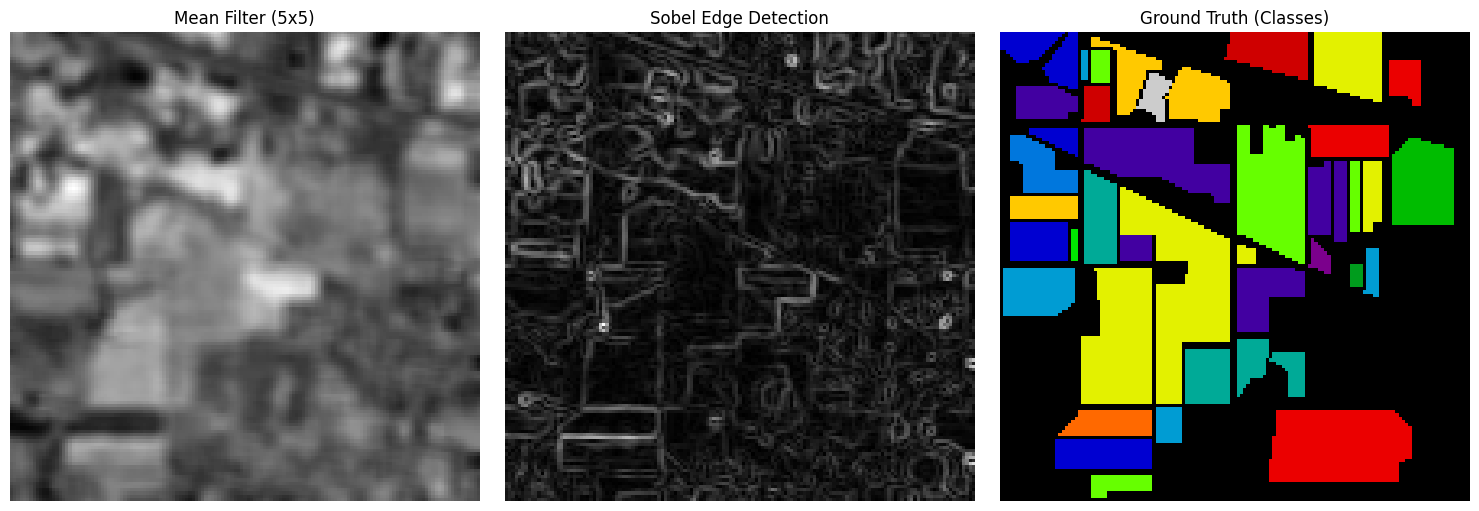

In [12]:
# 5. Mean Filter (Blurring)
print("Running Mean Filter (this may take a moment)...")
mean_res = mean_filter(band, size=5)

# 6. Sobel Edge Detection
print("Running Sobel Edge Detection...")
edge_res = gradient_filter(band)

# Visualization
plt.figure(figsize=(15, 5))

# Mean Filter Result
plt.subplot(1, 3, 1)
plt.imshow(mean_res, cmap='gray')
plt.title('Mean Filter (5x5)')
plt.axis('off')

# Edge Detection Result
plt.subplot(1, 3, 2)
plt.imshow(edge_res, cmap='gray')
plt.title('Sobel Edge Detection')
plt.axis('off')

# Ground Truth (for comparison)
if gt_map is not None:
    plt.subplot(1, 3, 3)
    plt.imshow(gt_map, cmap='nipy_spectral')
    plt.title('Ground Truth (Classes)')
    plt.axis('off')

plt.tight_layout()
plt.savefig('outputs/spatial_filters.png')
plt.show()